# Tutorial: Computing Sharpe Ratio of a Stock Using

Auther: Engineer Investor (@egr_investor)

Date: 04/09/24



## Introduction

In this tutorial, we're going to learn how to compute the Sharpe Ratio, a measure used to evaluate the risk-adjusted return of an investment. The Sharpe Ratio is particularly useful because it not only considers the returns of an investment but also its risk. To compute it, we'll use Python and real stock return data alongside the return data of Treasury Bills (T-Bills) as our risk-free rate benchmark.

## Load packages

In [ ]:
pip install yfinance pandas matplotlib numpy

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pickle
import os
import yfinance as yf
import numpy as np
from typing import Optional, Union

## Save Data

Before diving into the computations, it's crucial to ensure our data is correctly saved and accessible for analysis. For stock return data, we can use various sources, such as financial APIs or historical price data from financial websites. Similarly, T-Bill return data can be fetched from governmental websites or financial data providers.

In [ ]:
def load_df_from_pickle(filename):
  with open(filename, 'rb') as f:
    df = pickle.load(f)
  return df

In [ ]:
# Check if the file exists
if os.path.isfile('tbill_3mo_returns.pkl'):
    # If the file exists, load the dataframe to pickle
    df = load_df_from_pickle('tbill_3mo_returns.pkl')

    print('Found saved file.')
    print(df)
else:
  # Define the URL where the data is located
  url = "https://fred.stlouisfed.org/data/DTB3.txt"

  # Send a GET request to the URL to download the data
  response = requests.get(url)
  data = response.text

  # Identify the start of the actual data (skipping the header)
  start_line = data.find('DATE')
  end_line = data.find('\n', start_line)
  header = data[start_line:end_line].split()

  # Split the data into lines and then into a list of lists
  data_lines = data[end_line:].strip().split('\n')
  data_list = [line.split() for line in data_lines]

  # Create a pandas DataFrame
  df = pd.DataFrame(data_list, columns=header)

  # Convert the date string to a pandas datetime object
  df['DATE'] = pd.to_datetime(df['DATE'], format="%Y-%m-%d")

  # Convert the value to a float and handle '.', which denotes missing data
  df['Yield'] = pd.to_numeric(df['VALUE'], errors='coerce')

  # Drop rows with missing data
  df = df.dropna()

  # Drop unneeded column
  df = df.drop(columns=['VALUE'])

  # Set the date as the index of the DataFrame
  df.set_index('DATE', inplace=True)

  # Calculate the daily returns
  df['Change'] = df['Yield'].diff()

Found saved file.
            Yield  Change
DATE                     
1954-01-04   1.33     NaN
1954-01-05   1.28   -0.05
1954-01-06   1.28    0.00
1954-01-07   1.31    0.03
1954-01-08   1.31    0.00
...           ...     ...
2024-04-01   5.23    0.00
2024-04-02   5.22   -0.01
2024-04-03   5.22    0.00
2024-04-04   5.21   -0.01
2024-04-05   5.23    0.02

[17557 rows x 2 columns]


In [ ]:
tbill_3mo_returns = df['Yield']

# Convert daily yield time-series to monthly
monthly_yields = df['Yield'].resample('M').mean()

In [ ]:
monthly_yields

DATE
1954-01-31    1.180000
1954-02-28    0.968889
1954-03-31    1.032174
1954-04-30    0.966364
1954-05-31    0.763000
                ...   
2023-12-31    5.241500
2024-01-31    5.224762
2024-02-29    5.238500
2024-03-31    5.239000
2024-04-30    5.222000
Freq: M, Name: Yield, Length: 844, dtype: float64

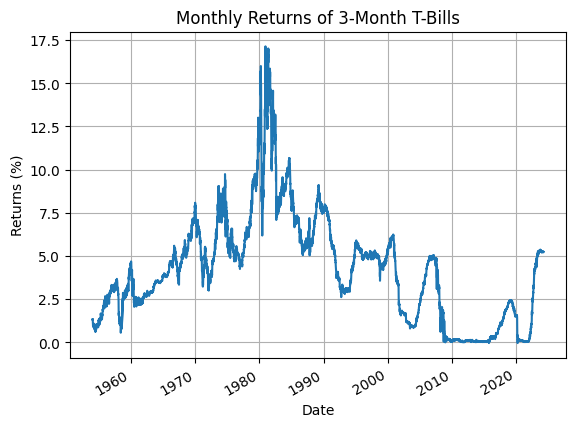

In [ ]:
# Plot the monthly returns
plt.figure()
df['Yield'].plot()
plt.title('Monthly Returns of 3-Month T-Bills')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.show()

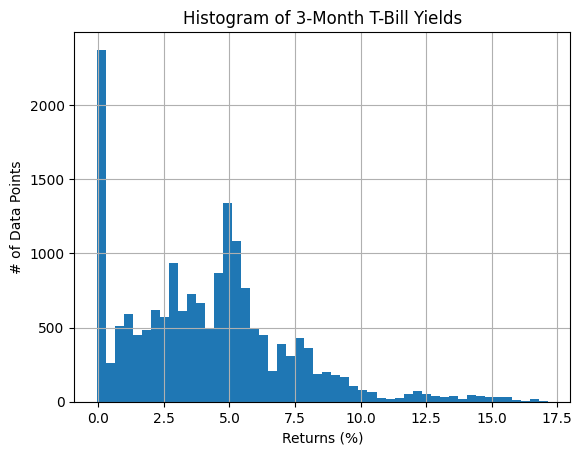

In [ ]:
df['Yield'].hist(bins=50)
plt.title('Histogram of 3-Month T-Bill Yields')
plt.xlabel('Returns (%)')
plt.ylabel('# of Data Points')
plt.show()

In [ ]:
def convert_to_monthly_rates(annual_rates: np.ndarray, periods=12) -> np.ndarray:
  """
  This function converts annual rates to monthly rates.

  Args:
     annual_rates: A float representing the annual interest rate.

  Returns:
     A float representing the monthly interest rate.
  """

  monthly_rates = (1 + annual_rates) ** (1/periods) - 1

  return monthly_rates

In [ ]:
# Example usage
annual_rate = 0.05  # Annual interest rate of 5%
monthly_rate = convert_to_monthly_rates(annual_rate)

print(f"Annual interest rate: {annual_rate:.4f}")
print(f"Monthly interest rate: {monthly_rate:.4f}")

Annual interest rate: 0.0500
Monthly interest rate: 0.0041


DATE
1954-01-04    0.073033
1954-01-05    0.071095
1954-01-06    0.071095
1954-01-07    0.072262
1954-01-08    0.072262
                ...   
2024-04-01    0.164682
2024-04-02    0.164526
2024-04-03    0.164526
2024-04-04    0.164370
2024-04-05    0.164682
Name: Monthly T-Bill Yield, Length: 17557, dtype: float64


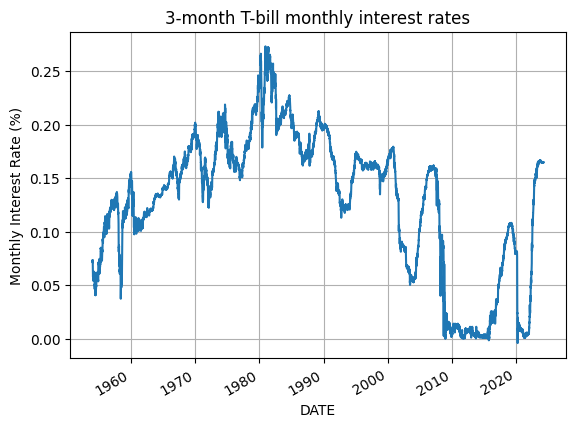

In [ ]:
# Convert daily yield time-series to monthly
df['Monthly T-Bill Yield'] = convert_to_monthly_rates(df['Yield'])

print(df['Monthly T-Bill Yield'])

plt.figure()
df['Monthly T-Bill Yield'].plot()
plt.title('3-month T-bill monthly interest rates')
plt.ylabel('Monthly Interest Rate (%)')
plt.grid(True)
plt.show()

In [ ]:
# Example of how to sample data monthly
df['Monthly T-Bill Yield'].resample('M').mean()

DATE
1954-01-31    0.066947
1954-02-28    0.058058
1954-03-31    0.060869
1954-04-30    0.057895
1954-05-31    0.048364
                ...   
2023-12-31    0.164861
2024-01-31    0.164600
2024-02-29    0.164814
2024-03-31    0.164822
2024-04-30    0.164557
Freq: M, Name: Monthly T-Bill Yield, Length: 844, dtype: float64

### Save data

In [ ]:
# Functions to save and load df['Yield'] to Pickle
def save_df_to_pickle(df, filename):
  with open(filename, 'wb') as f:
    pickle.dump(df, f)

# Check if the file exists
if not os.path.isfile('tbill_3mo_returns.pkl'):
    # If the file does not exist, save the dataframe to pickle
    save_df_to_pickle(df, 'tbill_3mo_returns.pkl')

## Get Stock Return Data

Getting accurate stock return data is the first step in our analysis. This can be done by fetching historical stock prices and calculating the returns over your period of interest. Python libraries like pandas and yfinance can make this task easier by allowing us to download stock data directly into our Python environment.

In [ ]:
ticker = 'VFINX'
start_date = '1999-03-01'
end_date = '2024-03-31'
frequency = '1d'

In [ ]:
# Get the values of df['Monthly T-Bill Yield'] between a specific date range

monthly_yields_subset = df['Monthly T-Bill Yield'][start_date:end_date]

print(monthly_yields_subset.resample('M').mean())

DATE
1999-03-31    0.151606
1999-04-30    0.148900
1999-05-31    0.152621
1999-06-30    0.153801
1999-07-31    0.153533
                ...   
2023-11-30    0.165303
2023-12-31    0.164861
2024-01-31    0.164600
2024-02-29    0.164814
2024-03-31    0.164822
Freq: M, Name: Monthly T-Bill Yield, Length: 301, dtype: float64


In [ ]:
def get_stock_return_data(ticker, start_date, end_date, frequency='1d'):
    """
    Fetches stock return data for a specific ticker from Yahoo Finance.

    :param ticker: The stock ticker symbol as a string.
    :param start_date: The start date for the data retrieval in 'YYYY-MM-DD' format.
    :param end_date: The end date for the data retrieval in 'YYYY-MM-DD' format.
    :param frequency: The frequency of the data. Default is '1d' (daily).
                      Other options include '1wk' (weekly) and '1mo' (monthly).
    :return: A pandas DataFrame containing the stock return data.
    """
    # Fetch the historical market data
    data = yf.download(ticker, start=start_date, end=end_date, interval=frequency)

    # Calculate returns
    data['Returns'] = data['Adj Close'].pct_change()

    return data

In [ ]:
# Example usage of get_stock_return_data
df_stock_data = get_stock_return_data(ticker, start_date, end_date, frequency)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_stock_data

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
1999-03-01,114.839996,114.839996,114.839996,114.839996,73.789986,0,NaN
1999-03-02,113.849998,113.849998,113.849998,113.849998,73.153885,0,-0.008620
1999-03-03,114.080002,114.080002,114.080002,114.080002,73.301613,0,0.002019
1999-03-04,115.849998,115.849998,115.849998,115.849998,74.438950,0,0.015516
1999-03-05,118.529999,118.529999,118.529999,118.529999,76.161003,0,0.023134
...,...,...,...,...,...,...,...
2024-03-22,482.989990,482.989990,482.989990,482.989990,482.989990,0,-0.004288
2024-03-25,481.510010,481.510010,481.510010,481.510010,481.510010,0,-0.003064
2024-03-26,480.160004,480.160004,480.160004,480.160004,480.160004,0,-0.002804


In [ ]:
def calculate_monthly_returns(stock_prices):
  """
  This function calculates the monthly returns of a stock based on a list of closing prices.

  Args:
      stock_prices: A list of floats representing the closing stock prices over time.

  Returns:
      A list of floats representing the monthly returns of the stock.

  Raises:
      ValueError: If the provided list has less than two elements.
  """
  if len(stock_prices) < 2:
    raise ValueError("List of stock prices must contain at least two elements.")

  monthly_stock_returns = (stock_prices[1:] - stock_prices[:-1]) / stock_prices[:-1]

  return monthly_stock_returns

In [ ]:
# Example usage
stock_prices = np.array([100, 105, 110, 108, 112])  # Sample closing prices
monthly_returns = calculate_monthly_returns(stock_prices)

# Print the monthly returns
for i, return_rate in enumerate(monthly_returns):
  print(f"Month {i+1} return: {return_rate:.2%}")

Month 1 return: 5.00%
Month 2 return: 4.76%
Month 3 return: -1.82%
Month 4 return: 3.70%


In [ ]:
# Calculate monthly stock returns using df_stock_data['Adj Close']
monthly_stock_returns = calculate_monthly_returns(np.array(df_stock_data['Adj Close']))

In [ ]:
def calculate_monthly_returns_from_dataframe(df: pd.DataFrame,
                                             price_column: str,
                                             frequency: str = 'M',
                                             date_column: Optional[str] = None) -> pd.Series:
    """
    Calculate monthly returns from a time series of stock prices.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the stock prices time series.
    - price_column: str
        The name of the column containing the stock prices.
    - frequency (str, optional): The resampling frequency. Defaults to 'M' (monthly).
        Other valid frequencies include 'W' for weekly, 'D' for daily, etc.
    - date_column: Optional[str], default=None
        The name of the column containing the dates. If None, it's assumed that the DataFrame's index is already a DateTimeIndex.

    Returns:
    - pd.Series
        A Series with the monthly returns.
    """

    # If a date column is provided, set it as the index and convert it to datetime if necessary.
    if date_column:
        df = df.copy()
        df[date_column] = pd.to_datetime(df[date_column])
        df.set_index(date_column, inplace=True)

    # Ensure the DataFrame is sorted by the index (date).
    df.sort_index(inplace=True)

    # Resample to get the last price of each month and calculate monthly returns
    monthly_returns = df[price_column].resample(frequency).last().pct_change()

    return monthly_returns

# Example usage:
# Assuming `your_df` is your DataFrame, `Price` is the column with stock prices,
# and `Date` is the column with dates (if the DataFrame's index is not already a DateTimeIndex).
# monthly_returns = calculate_monthly_returns(your_df, 'Price', 'Date')


In [ ]:
# Write function to compute the compunded annualized growth rate of df['Adj Close']

def calc_cagr(df):
    """
    Computes the compound annual growth rate of a time series.

    :param df: A pandas DataFrame containing the time series data.
    :return: The compound annual growth rate as a float.
    """
    # Get the first and last values of the time series
    first_value = df.iloc[0]
    last_value = df.iloc[-1]

    # Calculate the number of years between the first and last values
    num_years = (df.index[-1] - df.index[0]).days / 365.25

    # Calculate the compound annual growth rate
    cagr = (last_value / first_value) ** (1 / num_years) - 1

    return cagr

In [ ]:
def calculate_cagr_and_std(df, frequency='1mo'):
   """
   Calculates the compound annual growth rate (CAGR) and standard deviation of stock returns on a percentage basis.

   Args:
       df (pd.DataFrame): A pandas DataFrame containing stock prices.

   Returns:
       tuple: A tuple containing two floats:
           - CAGR (compound annual growth rate)
           - std (standard deviation of returns)
   """

   # Calculate percentage returns
   returns = df['Adj Close'].pct_change()

   # Calculate CAGR using the provided cagr function
   cagr = calc_cagr(df['Adj Close'])

   if frequency == '1mo':
    return_periods = 12
   elif frequency == '1d':
    return_periods = 252
   elif frequency == '1wk':
    return_periods = 12
   else:
    raise ValueError('Imprper return frequency value')

   # Calculate annualized standard deviation of returns
   std = returns.std() * (return_periods**0.5)  # Assuming 252 trading days per year

   # Convert CAGR and standard deviation to percentages
   cagr_pct = cagr * 100
   std_pct = std * 100

   return cagr_pct, std_pct


In [ ]:
# Compute Compounded Annual Growth Rate (CAGR) and annualized standard deviation as a percentage
cagr_pct, _ = calculate_cagr_and_std(df_stock_data, frequency)
std_pct = np.std(100*df_stock_data['Adj Close'].resample('M').last().pct_change()) * np.sqrt(12)
print("CAGR:", np.round(cagr_pct, 2), "%")
print("Standard deviation of returns:", np.round(std_pct, 2), "%")

CAGR: 7.8 %
Standard deviation of returns: 15.35 %


In [ ]:
# Merge the two dataframes on the index (date)
merged_df = pd.merge(df, df_stock_data, left_index=True, right_index=True)

In [ ]:
monthly_stock_return = calculate_monthly_returns_from_dataframe(merged_df, price_column='Adj Close')

monthly_stock_return

1999-03-31         NaN
1999-04-30    0.038520
1999-05-31   -0.023891
1999-06-30    0.055560
1999-07-31   -0.031302
                ...   
2023-11-30    0.091196
2023-12-31    0.045351
2024-01-31    0.016657
2024-02-29    0.053287
2024-03-31    0.029030
Freq: M, Name: Adj Close, Length: 301, dtype: float64

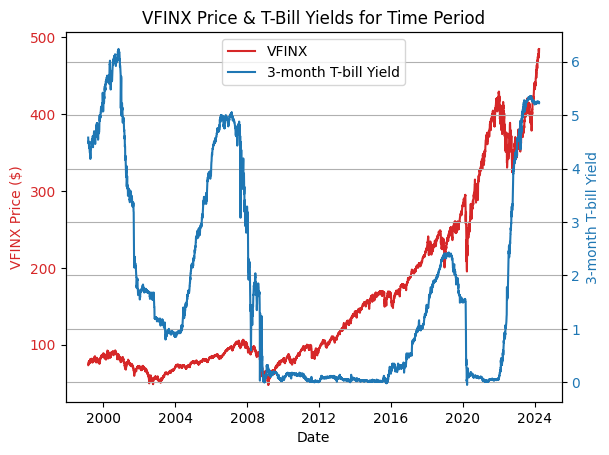

In [ ]:
# Using dataframe merged_df: Make a plot of 'Adj Close' on the left y-axis and 'Yield' on the right y-axis using matplotlib

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(ticker + ' Price ($)', color=color)
ax1.plot(merged_df['Adj Close'], color=color, label=ticker)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('3-month T-bill Yield', color=color)
ax2.plot(merged_df['Yield'], color=color, label='3-month T-bill Yield')
ax2.tick_params(axis='y', labelcolor=color)

lines = ax1.lines + ax2.lines  # Combine line objects from both axes
labels = [l.get_label() for l in lines]  # Get their labels
ax2.legend(lines, labels, loc='upper center')  # Adjust location as needed
plt.title(ticker + ' Price & T-Bill Yields for Time Period')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the CAGR of the 'Adj Close' column
cagr_ticker = calc_cagr(merged_df['Adj Close'])
print("CAGR of " + ticker + ":", np.round(100*cagr_ticker, 2), '%')

CAGR of VFINX: 7.8 %


# Compute Sharpe Ratio

The Sharpe Ratio is defined as the difference between the returns of the investment and the risk-free rate divided by the standard deviation of the investment's excess returns. Mathematically, it's expressed as:

$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$

When the return series for both the portfolio and the risk-free asset are available, the ex-post Sharpe Ratio is calculated as

$D_i = R_{pi} - R_{f}$

$\text{Sharpe Ratio} = \frac{\bar{D}}{\sigma_D} = \frac{\frac{1}{n} \sum_{i=1}^{n} D_i}{\sqrt{\frac{1}{n-1} \sum_{i=1}^{n}(D_i - \bar{D})^2}}$

The Sharpe Ratio based on monthly returns is annualized as

$\text{Sharpe Ratio}_{\text{annualized}} = \sqrt{12} \times \text{Sharpe Ratio}_{\text{monthly}}$


To compute the Sharpe Ratio in Python, we first need to calculate the mean return of the stock, the mean return of the risk-free rate (T-Bills), and the standard deviation of the stock's returns.

Source: https://www.portfoliovisualizer.com/faq#

In [ ]:
# Calculate the difference in returns between r_p and r_f
portfolio_returns = 100*df_stock_data['Adj Close'].resample('M').last().pct_change()
risk_free_rate = df['Yield'][start_date:end_date].resample('M').mean() / 12

In [ ]:
# Calculate excess returns
excess_returns = portfolio_returns - risk_free_rate

# Calculate the average of excess returns
average_excess_return = np.mean(excess_returns)

# Calculate the standard deviation of excess returns
std_dev_excess_returns = np.std(excess_returns)

# Calculate the Sharpe Ratio
sharpe_ratio = average_excess_return / std_dev_excess_returns

# Annualize the Sharpe Ratio assuming monthly returns
sharpe_ratio_annualized = sharpe_ratio * np.sqrt(12)

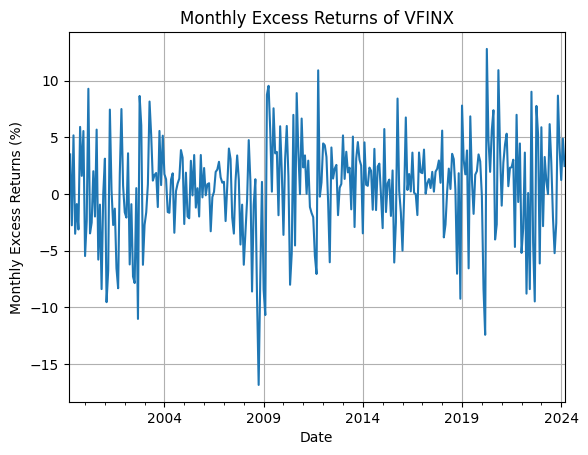

In [ ]:
plt.figure()
excess_returns.plot()
plt.title('Monthly Excess Returns of ' + ticker)
plt.ylabel('Monthly Excess Returns (%)')
plt.grid()
plt.show()

In [ ]:
print('Average Excess Returns (%):', np.round(average_excess_return, 3))
print('Standard deviation of Excess Returns (%):', np.round(std_dev_excess_returns, 3))
print('Sharpe Ratio (Monthly):', np.round(sharpe_ratio, 3))
print('Sharpe Ratio (Annualized):', np.round(sharpe_ratio_annualized, 3))

Average Excess Returns (%): 0.565
Standard deviation of Excess Returns (%): 4.442
Sharpe Ratio (Monthly): 0.127
Sharpe Ratio (Annualized): 0.441


In [ ]:
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate, frequency_periods=12):
  """
  This function calculates the Sharpe Ratio of a portfolio.

  Args:
      portfolio_returns (numpy.ndarray): A numpy array of portfolio returns.
      risk_free_rate (float): The risk-free rate of return.
      frequency_periods (int): The number of periods per year (e.g., 12 for monthly data).

  Returns:
      float: The Sharpe Ratio of the portfolio.
  """

  # Calculate excess returns
  excess_returns = portfolio_returns - risk_free_rate

  # Calculate the average of excess returns
  average_excess_return = np.mean(excess_returns)

  # Calculate the standard deviation of excess returns
  std_dev_excess_returns = np.std(excess_returns)

  # Calculate the Sharpe Ratio
  sharpe_ratio = average_excess_return / std_dev_excess_returns

  # Annualize the Sharpe Ratio assuming monthly returns
  sharpe_ratio_annualized = sharpe_ratio * np.sqrt(frequency_periods)

  return sharpe_ratio_annualized


In [ ]:
# Compute Sharpe Ratio
sr_annualized = calculate_sharpe_ratio(portfolio_returns, risk_free_rate)

print('Sharpe Ratio (Annualized):', np.round(sharpe_ratio_annualized, 3))

Sharpe Ratio (Annualized): 0.441


In [ ]:
print('Stock:', ticker)
print('Start Date:', start_date)
print('End Date:', end_date)
print("CAGR:", np.round(cagr_pct, 2), "%")
print("Standard Deviation of Returns (Annualized):", np.round(std_pct, 2), "%")
print('Sharpe Ratio (Annualized):', np.round(sharpe_ratio_annualized, 2))

Stock: VFINX
Start Date: 1999-03-01
End Date: 2024-03-31
CAGR: 7.8 %
Standard Deviation of Returns (Annualized): 15.35 %
Sharpe Ratio (Annualized): 0.44


## Compare Results to Portfolio Visualizer

The figure below from Portfolio Visualizer shows strong agreement with our computations in this tutorial. The slight difference in CAGR may be due to a slight timing misalignment and can be investigation in the future.

Portfolio Analysis Results (Apr 1999 - Mar 2024)

Source: https://www.portfoliovisualizer.com/backtest-portfolio?s=y&sl=4qxp2lo3sxekVqp1buNiJL

In [ ]:
from IPython.display import Image
Image(url='https://imgur.com/BN2PvGX.png')

## Conclusion

The Sharpe Ratio is a valuable metric for investors and analysts looking to understand the risk-adjusted returns of their investments. By comparing the performance of different investments through the lens of the Sharpe Ratio, one can make more informed decisions that take into account both return and risk. This tutorial has guided you through the steps of computing the Sharpe Ratio using Python, from fetching the necessary data to performing the calculation.

Remember, while the Sharpe Ratio is a powerful tool, it's just one of many metrics available for evaluating investments. Always consider using a combination of different metrics to get a comprehensive view of your investment's performance.